# The Dataset

downloading Emotions dataset from HuggingFace Hub

In [1]:
from datasets import load_dataset
emotions = load_dataset("emotion")

c:\Users\matin\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_ds = emotions["train"]

In [3]:
train_ds[:6]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy',
  'ive been feeling a little burdened lately wasnt sure why that was'],
 'label': [0, 0, 3, 2, 3, 0]}

we cahnge the format so that we can use matplotlib to visualize the data

In [4]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


In [5]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

In [6]:
df["label_name"] = df["label"].apply(label_int2str)

In [7]:
df

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


As can be seen the data is unbalanced, As for example, the number of texts containing joy is much more than surprise.

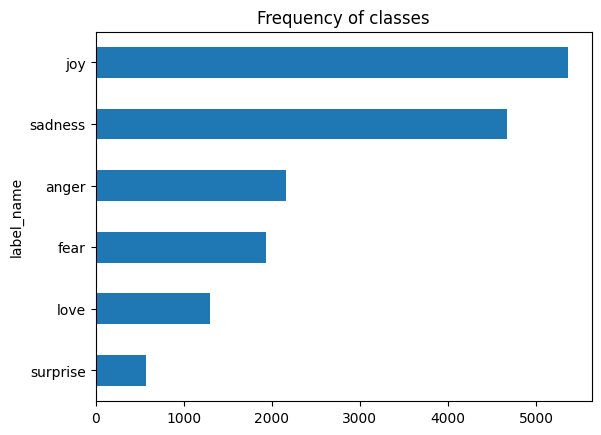

In [8]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of classes")
plt.show()

### How long are our tweets?

<Axes: title={'center': 'words per tweet'}, xlabel='label_name'>

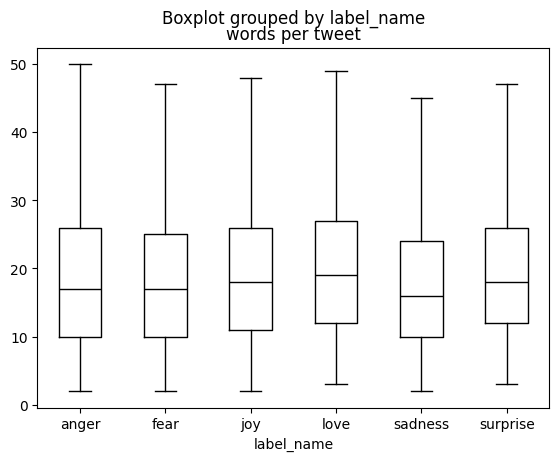

In [9]:
df["words per tweet"] = df["text"].str.split().apply(len)
df.boxplot("words per tweet", by="label_name", grid=False, showfliers=False, color="black")

We reset the format as we no longer need it

In [10]:
emotions.reset_format()

# From Text to Tokens